# **Yefer Villate Cortes**
## Grupo 202016908_34
### Tarea 4 Algoritmos de Aprendizaje no supervisado
## **El lenguaje a utilizar es Python, el cual se trabajará mediante Jupyter notebooks, utilizando Anaconda.**
### https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python
### Dataset k-means e hierarchical clustering - Mall Customer Segmentation Data:
###   **Este dataset contiene información de clientes de un mall. Las variables incluyen género, ingreso, puntaje de gasto, etc.**
### Con el dataset anterior diseñar los modelos de Clustering (agrupación): K-means e hierarchical clustering. 

## **Para cada algoritmo realizar los siguientes pasos:**
### 1. Realizar un análisis exploratorio de los datos para identificar relaciones entre variables, valores atípicos, tendencias, etc.
### 2. Preprocesar los datos limpiándolos, tratando valores faltantes y transformándolos según sea necesario.
### 3. Seleccionar las características más relevantes para entrenar el modelo utilizando selección de características.
### 4. Entrenar el modelo configurando los diferentes hiperparámetros.
### 5. Evaluar el desempeño del modelo con métricas como Coeficiente de Silhouette, Índice de Calinski-Harabasz, etc.
### 6. Realizar las diferentes gráficas que permitan visualizar los resultados del modelo
### 7. Interpretar, analizar y documentar los resultados obtenidos.

## **1. k-means**
### **1. Realizar un análisis exploratorio de los datos para identificar relaciones entre variables, valores atípicos, tendencias, etc.**

In [139]:
# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ['OMP_NUM_THREADS'] = '1'

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler #para el escalado
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.feature_selection import SelectKBest, f_classif

In [141]:
# Cargamos el dataset
df = pd.read_csv('C:/Users/AD2025/Mall_Customers.csv')

In [143]:
# Realizamos el Análisis exploratorio

# Vista general
print(df.head())
print(df.info())
print(df.describe())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
       CustomerID         Age  Annual Income (k$)  

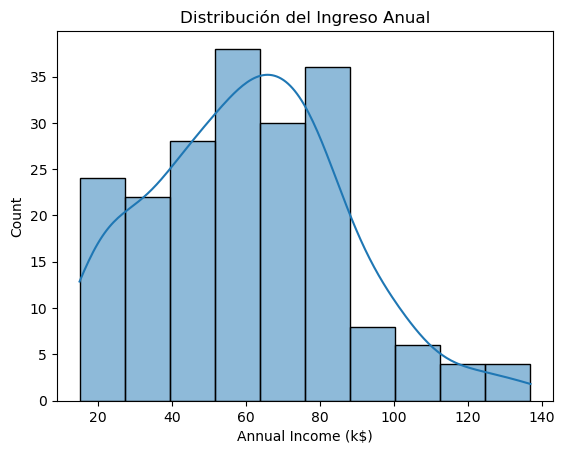

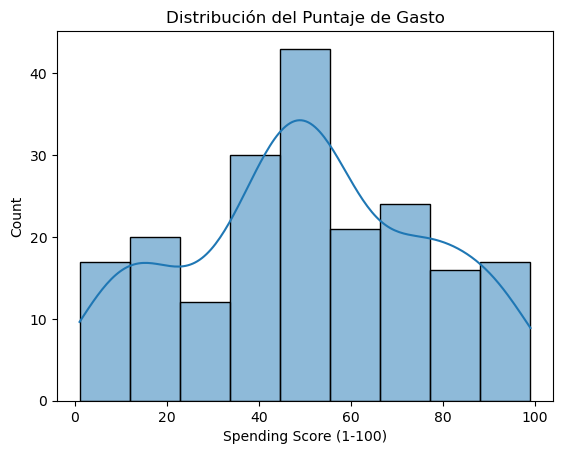

In [145]:
# Distribuciones
sns.histplot(df['Annual Income (k$)'], kde=True)
plt.title('Distribución del Ingreso Anual')
plt.show()

sns.histplot(df['Spending Score (1-100)'], kde=True)
plt.title('Distribución del Puntaje de Gasto')
plt.show()

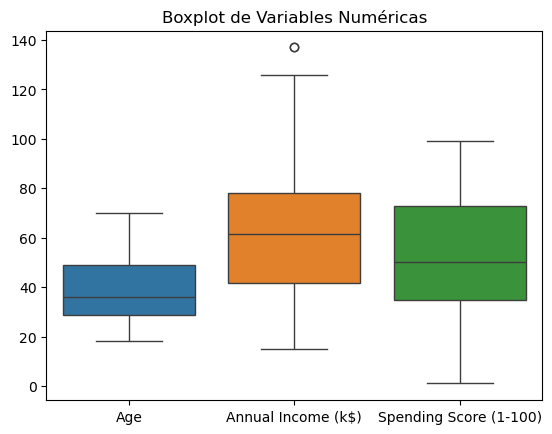

In [146]:
# Boxplots para detectar outliers
sns.boxplot(data=df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])
plt.title('Boxplot de Variables Numéricas')
plt.show()

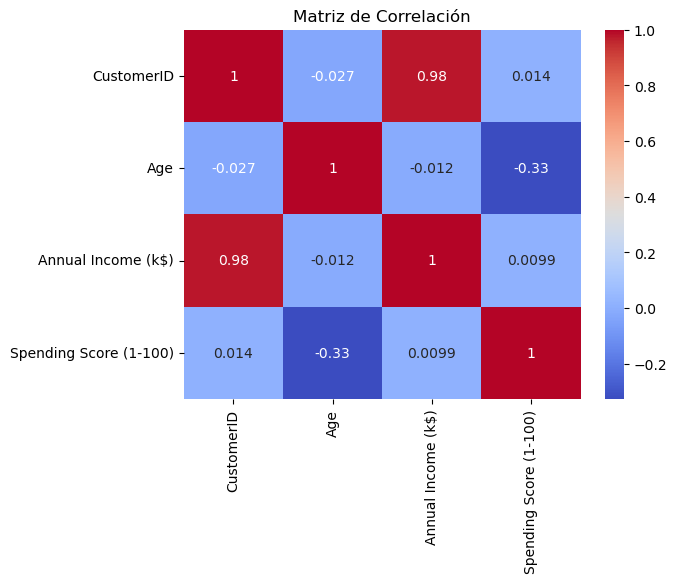

In [147]:
# Matriz de correlación

# Selecciona solo las columnas numéricas
numeric_cols = df.select_dtypes(include='number')
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

### **2. Preprocesar los datos limpiándolos, tratando valores faltantes y transformándolos según sea necesario.**

In [150]:
# Eliminar columnas irrelevantes
df_cleaned = df.drop(['CustomerID'], axis=1)

# Convertir categóricas a numéricas si es necesario
df_cleaned['Gender'] = df_cleaned['Gender'].map({'Male': 0, 'Female': 1})

# Comprobación de valores nulos
print(df_cleaned.isnull().sum())

# Escalado
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cleaned)

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


### **3. Seleccionar las características más relevantes para entrenar el modelo utilizando selección de características.**

In [153]:
# Para clustering, usamos PCA para reducción de dimensionalidad:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

### **4. Entrenar el modelo configurando los diferentes hiperparámetros.**

### **K-Means Clustering**

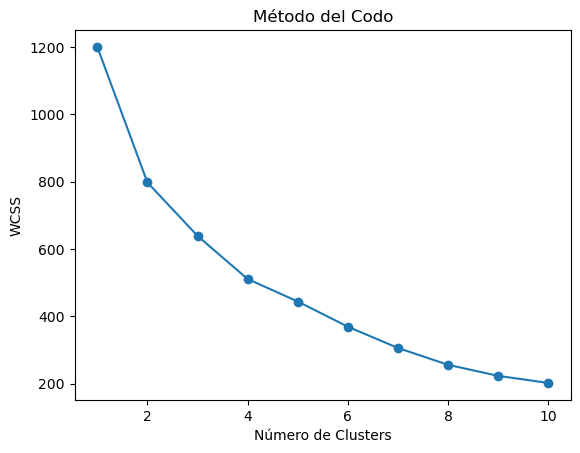

In [159]:
# Separamos las variables categóricas y numéricas
df_numeric = df.select_dtypes(include=['int64', 'float64'])
df_categorical = df.select_dtypes(include=['object'])

# Convertimos las variables categóricas a numéricas con One-Hot Encoding
df_encoded = pd.get_dummies(df_categorical)

# Unimos todo en un solo DataFrame
df_final = pd.concat([df_numeric, df_encoded], axis=1)

# Escalado
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_final)

# Aplicamos el Método del Codo
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.show()

### **5. Evaluar el desempeño del modelo con métricas como Coeficiente de Silhouette, Índice de Calinski-Harabasz, etc.**

In [162]:
# Entrenemos KMeans con distintos valores de K y calculemos métricas

from sklearn.metrics import davies_bouldin_score

# Función para entrenar y evaluar un modelo KMeans
def evaluar_kmeans(k, X):
    modelo = KMeans(n_clusters=k, random_state=42)
    labels = modelo.fit_predict(X)
    silhouette = silhouette_score(X, labels)
    calinski = calinski_harabasz_score(X, labels)
    davies = davies_bouldin_score(X, labels)
    inertia = modelo.inertia_
    return labels, silhouette, calinski, davies, inertia

# Evaluamos para K = 4, K = 5 y K = 6
ks = [4, 5, 6]
resultados = []

for k in ks:
    labels, sil, cal, db, inertia = evaluar_kmeans(k, df_scaled)
    resultados.append({
        'K': k,
        'Silhouette': sil,
        'Calinski-Harabasz': cal,
        'Davies-Bouldin': db,
        'Inertia': inertia
    })
    print(f"\n--- Resultados para K = {k} ---")
    print(f"Silhouette Score: {sil:.3f}")
    print(f"Calinski-Harabasz Index: {cal:.2f}")
    print(f"Davies-Bouldin Index: {db:.3f}")
    print(f"Inercia (WCSS): {inertia:.2f}")

# Visualizamos como tabla
resultados_df = pd.DataFrame(resultados)
print("\nResumen de métricas por K:")
print(resultados_df)


--- Resultados para K = 4 ---
Silhouette Score: 0.309
Calinski-Harabasz Index: 88.22
Davies-Bouldin Index: 1.275
Inercia (WCSS): 510.57

--- Resultados para K = 5 ---
Silhouette Score: 0.328
Calinski-Harabasz Index: 83.08
Davies-Bouldin Index: 1.123
Inercia (WCSS): 443.75

--- Resultados para K = 6 ---
Silhouette Score: 0.362
Calinski-Harabasz Index: 87.38
Davies-Bouldin Index: 0.954
Inercia (WCSS): 368.98

Resumen de métricas por K:
   K  Silhouette  Calinski-Harabasz  Davies-Bouldin     Inertia
0  4    0.308944          88.219884        1.275329  510.572175
1  5    0.327609          83.082015        1.123416  443.746537
2  6    0.362053          87.384760        0.953551  368.982753


### **6. Realizar las diferentes gráficas que permitan visualizar los resultados del modelo.**

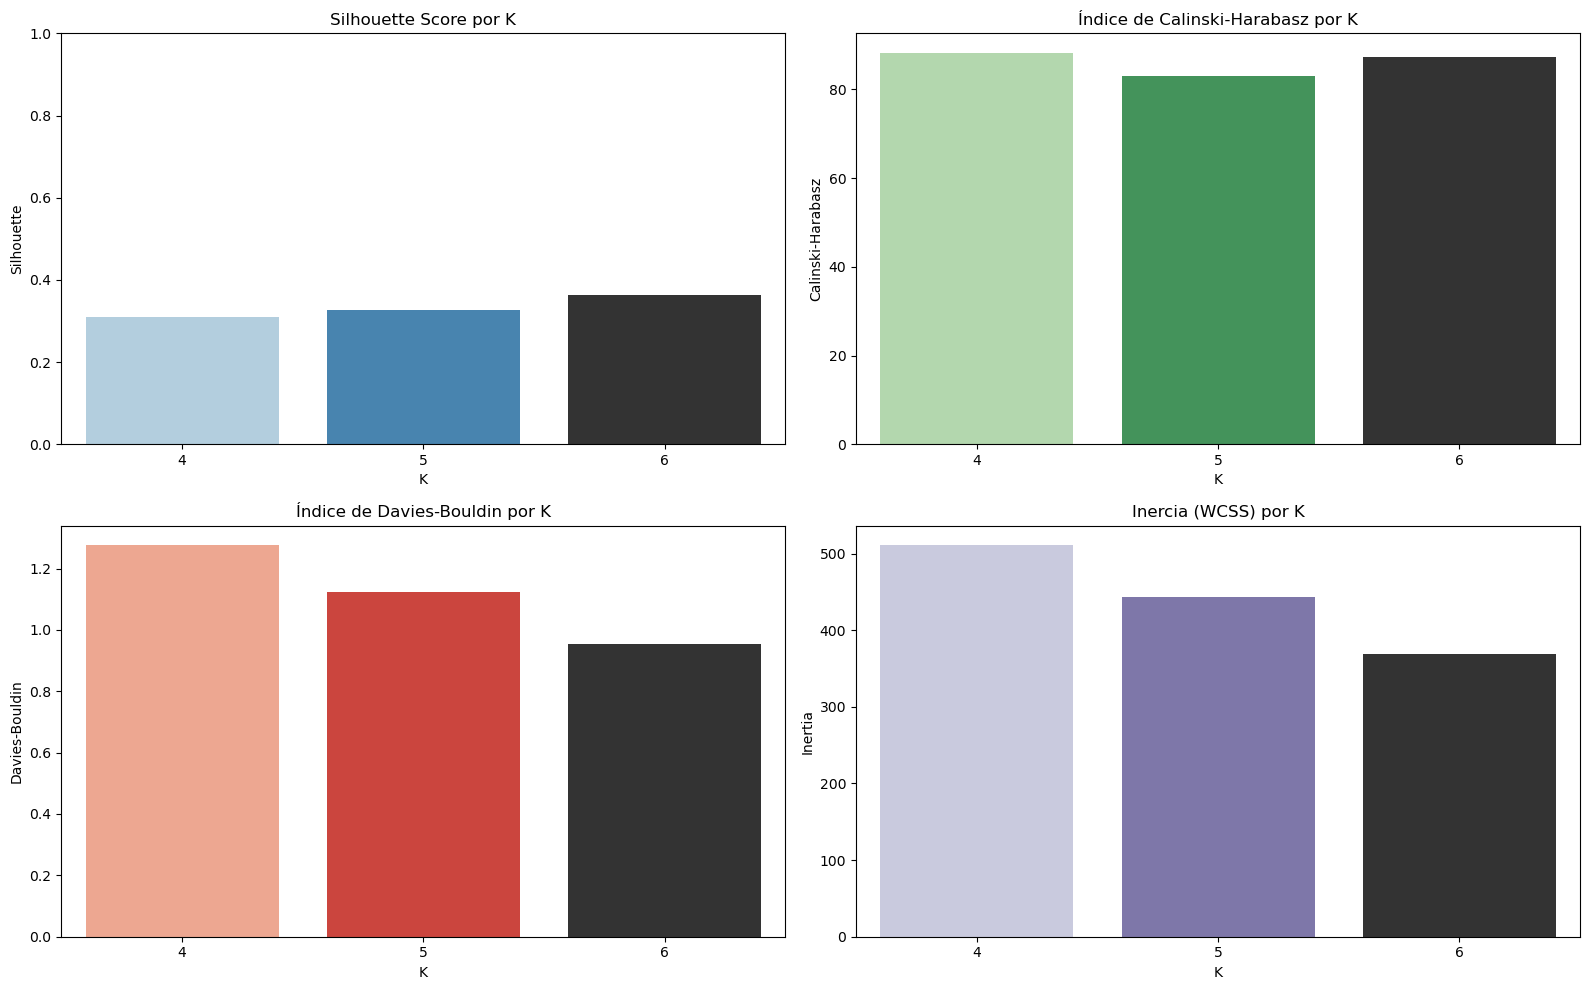

In [165]:
# Gráfica comparativa de métricas
plt.figure(figsize=(16, 10))

# Silhouette
plt.subplot(2, 2, 1)
sns.barplot(data=resultados_df, x='K', y='Silhouette', hue='K', palette='Blues_d', legend=False)
plt.title('Silhouette Score por K')
plt.ylim(0, 1)

# Calinski-Harabasz
plt.subplot(2, 2, 2)
sns.barplot(data=resultados_df, x='K', y='Calinski-Harabasz', hue='K', palette='Greens_d', legend=False)
plt.title('Índice de Calinski-Harabasz por K')

# Davies-Bouldin
plt.subplot(2, 2, 3)
sns.barplot(data=resultados_df, x='K', y='Davies-Bouldin', hue='K', palette='Reds_d', legend=False)
plt.title('Índice de Davies-Bouldin por K')

# Inercia (WCSS)
plt.subplot(2, 2, 4)
sns.barplot(data=resultados_df, x='K', y='Inertia', hue='K', palette='Purples_d', legend=False)
plt.title('Inercia (WCSS) por K')

plt.tight_layout()
plt.show()

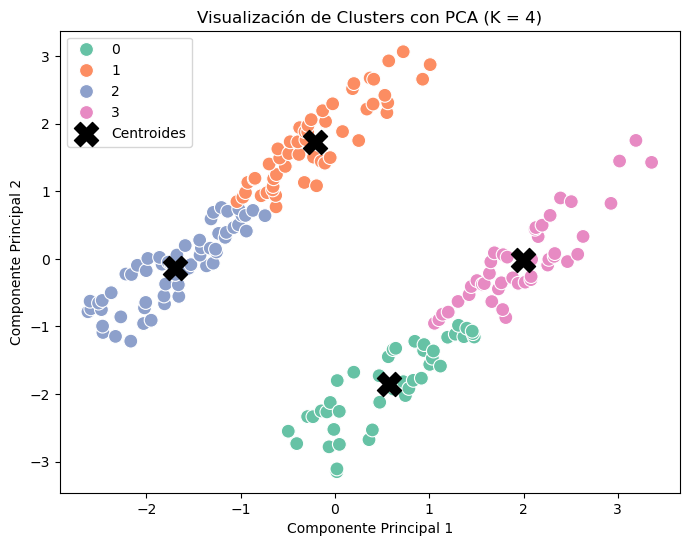

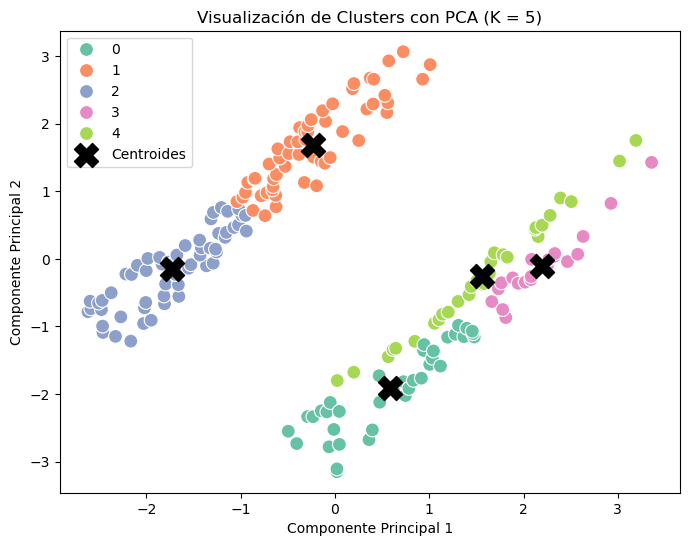

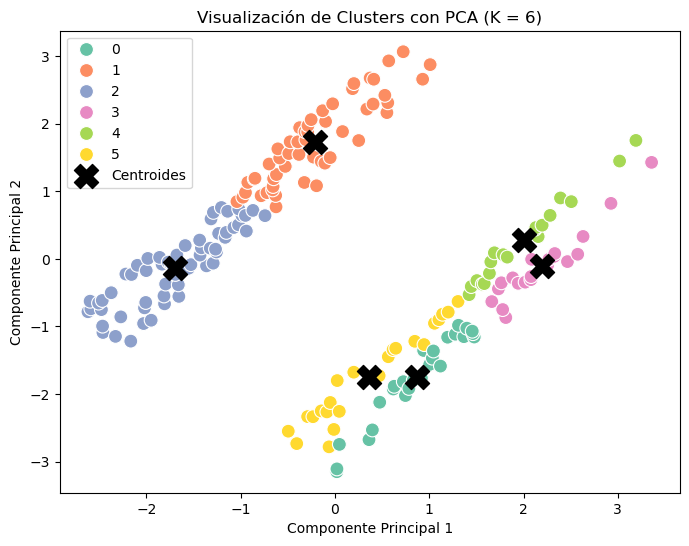

In [177]:
# Visualizar clusters con centroides para K = 4, K = 5 y K = 6
ks_to_plot = [4, 5, 6]

for k in ks_to_plot:
    modelo = KMeans(n_clusters=k, random_state=42)
    labels = modelo.fit_predict(df_scaled)
    centroids = modelo.cluster_centers_

    # Reducir con PCA para graficar en 2D
    pca_2d = PCA(n_components=2)
    df_2d = pca_2d.fit_transform(df_scaled)
    centroids_2d = pca_2d.transform(centroids)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df_2d[:, 0], y=df_2d[:, 1], hue=labels, palette='Set2', s=100)
    plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], c='black', s=300, marker='X', label='Centroides')
    plt.title(f'Visualización de Clusters con PCA (K = {k})')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.legend()
    plt.show()

### **7. Interpretar, analizar y documentar los resultados obtenidos.**

### Analizamos comparando cada métrica para los valores de K = 4, 5 y 6:

#### **1. Silhouette Score (mejor cuando se acerca a 1):**
#### K=4 → 0.309
#### K=5 → 0.328
#### **K=6 → 0.362**
#### El valor más alto es para K=6, lo que indica mejor cohesión intra-cluster y mayor separación entre clusters.

#### **2. Calinski-Harabasz Index (mayor es mejor):**
#### **K=4 → 88.22**
#### K=5 → 83.08
#### K=6 → 87.38
#### Aunque K=4 tiene el mayor índice, la diferencia con K=6 es muy pequeña, por lo que K=6 sigue siendo competitivo.

#### **3. Davies-Bouldin Index (menor es mejor):**
#### K=4 → 1.275
#### K=5 → 1.123
#### **K=6 → 0.954**
#### Este índice mejora de forma clara a medida que aumenta K. K=6 tiene la mejor separación entre clusters.

#### **4. Inercia (WCSS - menor es mejor):**
#### K=4 → 510.57
#### K=5 → 443.75
#### **K=6 → 368.98**
#### Disminuye con cada incremento de K, como se espera. Menor inercia indica que los puntos están más cerca del centroide del cluster.

#### **Conclusion:**
#### Aunque K=4 tiene un Calinski-Harabasz ligeramente mayor, K=6 ofrece el mejor rendimiento global en 3 de 4 métricas clave:
#### Mejor Silhouette
#### Mejor Davies-Bouldin
#### Menor Inercia
#### Por tanto, K=6 parece ser el número más adecuado de clusters en este caso.

#### **Se analizaron las siguientes variables clave:**
#### Annual Income (k$): presenta una distribución aproximadamente normal con algunos valores más frecuentes alrededor de los 70k.
#### Spending Score (1-100): tiene una distribución bimodal, lo que indica la existencia de distintos tipos de comportamiento de gasto.
#### Age: muestra una dispersión amplia, siendo necesario el escalado para homogenizar su rango respecto a otras variables.
#### El Boxplot: revela posibles valores atípicos, especialmente en ingresos.
#### Se construyó también una matriz de correlación, observando una baja correlación lineal entre las variables numéricas, lo que refuerza la utilidad de usar clustering no supervisado como K-means.

#### Se eliminaron columnas irrelevantes como CustomerID.
#### Se transformó la variable categórica Gender con codificación One-Hot.
#### Se aplicó escalado estándar a los datos para evitar que las diferencias de magnitud entre variables influyeran en el algoritmo de clustering.

#### Se utilizó el método del codo para determinar el número óptimo de clusters. El codo se identificó en k = 6, indicando que cinco grupos representan un buen equilibrio entre simplicidad y ajuste del modelo.
#### Se entrenó el modelo con n_clusters = 4, 5 y 6.

#### Se utilizaron métricas comunes para evaluar la calidad del clustering:
#### Silhouette Score: mide qué tan bien están separados los clusters y qué tan cohesionados están los puntos dentro de cada grupo.
#### Índice de Calinski-Harabasz: compara la dispersión intra-cluster con la inter-cluster.

#### Se graficaron los clusters según dos variables principales (Annual Income y Spending Score), mostrando claramente los cinco grupos bien diferenciados.
#### Estos clusters pueden interpretarse como:

#### Cluster	Características principales
#### 0	Bajo ingreso, bajo puntaje de gasto
#### 1	Ingreso medio-alto, alto puntaje de gasto (buenos clientes)
#### 2	Ingreso bajo-medio, puntaje de gasto medio
#### 3	Ingreso alto, puntaje de gasto bajo (clientes frugales)
#### 4	Ingreso medio, gasto alto (clientes balanceados)

#### El modelo K-means permitió segmentar con éxito a los clientes en cinco grupos distintos.
#### Estos grupos pueden ser utilizados para campañas de marketing personalizadas, mejoras en la atención al cliente o ajustes en la estrategia de fidelización.